In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def visualize(data, y, x, hues, chart):
    plt.figure(figsize=(12,8))
    match chart:
        case 'line':
            chart_type = sns.lineplot
        case 'bar':
            chart_type = sns.barplot
        case 'box':
            chart_type = sns.boxplot
    try:
        if len(hues) > 1:
            data['hues'] = data[hues].astype(str).agg('-'.join, axis=1)
        else:
            data['hues'] = data[hues[0]]

        chart_type(data=data,x = x, y = y, hue='hues', palette='viridis')

        plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}')
        plt.show()
    except (KeyError, ValueError):
        print(f"You've passed an incorrect column name.\n The correct ones are: \n{data.columns}")
    


In [78]:
import networkx as nx
from MaxCutProblem import MaxCutProblem
from solver import Solver

problem = MaxCutProblem()
# Create an Erdos-Renyi graph
graphs = problem.get_erdos_renyi_graphs([5, 7, 9])
dictionary = {}
for graph in graphs:
    solver = Solver(graph, relaxed=False, lagrangian=2, vertexcover=True)

    # Convert the graph to a NetworkX graph
    nx_graph = nx.Graph(list(graph.edge_list()))
    graph6_string = nx.to_graph6_bytes(nx_graph).decode('utf-8').strip()

    # Solve the problem using the solver
    bitstring, objvalue = solver.solve()
    print(f'Solution, objective value for graph {graph6_string} is {objvalue}')
    
    # Add the result to the dictionary
    dictionary[graph6_string] = objvalue

print(dictionary)

objective: x_0+x_1+x_2+x_3+x_4
optimal value found: 2.0
Solution, objective value for graph >>graph6<<DkO is 2.0
objective: x_0+x_1+x_2+x_3+x_4
optimal value found: 3.0
Solution, objective value for graph >>graph6<<Dm{ is 3.0
objective: x_0+x_1+x_2+x_3+x_4+x_5+x_6
optimal value found: 4.0
Solution, objective value for graph >>graph6<<FkPsg is 4.0
objective: x_0+x_1+x_2+x_3+x_4+x_5+x_6
optimal value found: 5.0
Solution, objective value for graph >>graph6<<Fm~]w is 5.0
objective: x_0+x_1+x_2+x_3+x_4+x_5+x_6+x_7+x_8
optimal value found: 5.0
Solution, objective value for graph >>graph6<<HkPsgZ@ is 5.0
objective: x_0+x_1+x_2+x_3+x_4+x_5+x_6+x_7+x_8
optimal value found: 7.0
Solution, objective value for graph >>graph6<<Hm~]x^^ is 7.0
{'>>graph6<<DkO': 2.0, '>>graph6<<Dm{': 3.0, '>>graph6<<FkPsg': 4.0, '>>graph6<<Fm~]w': 5.0, '>>graph6<<HkPsgZ@': 5.0, '>>graph6<<Hm~]x^^': 7.0}


### Configure the results you want to visualize under.



In [80]:
strings = ["results_papergraph_error_mitigation_{False, True}.csv",
"results_papergraph_qaoa_variant_{'vanilla', 'multiangle'}_warm_start_{False, True}_depth_{1, 4}_error_mitigation_{False, True}.csv",
"results_papergraph_qaoa_variant_{'vanilla', 'multiangle'}_warm_start_{False, True}_error_mitigation_{False, True}.csv",
"results_papergraph_warm_start_{False, True}_depth_{1, 4}_error_mitigation_{False, True}.csv",
"results_papergraph_warm_start_{False, True}_error_mitigation_{False, True}.csv"]

for file in strings:
    try:
        df = pd.read_csv(file, index_col=0)
        print(f"File: {file}")
        print(df['graph_name'].value_counts())
        print("\n")
    except FileNotFoundError:
        print(f"File not found: {file}")

if len(strings) >1:
    results = pd.concat([pd.read_csv(path, index_col=0) for path in strings])

else:
    results = pd.read_csv(strings[0],index_col=0)

results['classic_value'] = results['graph_name'].map(dictionary)
results['ratio'] = results['quantum_obj_value']/results['classic_value']
#rint(results.head())
print(results.columns)

File: results_papergraph_error_mitigation_{False, True}.csv
graph_name
>>graph6<<DkO        22
>>graph6<<Dm{        21
>>graph6<<FkPsg      20
>>graph6<<Fm~]w      20
>>graph6<<HkPsgZ@    20
>>graph6<<Hm~]x^^    19
Name: count, dtype: int64


File: results_papergraph_qaoa_variant_{'vanilla', 'multiangle'}_warm_start_{False, True}_depth_{1, 4}_error_mitigation_{False, True}.csv
graph_name
>>graph6<<DkO        537
>>graph6<<Dm{        537
>>graph6<<FkPsg      536
>>graph6<<Fm~]w      536
>>graph6<<HkPsgZ@    533
>>graph6<<Hm~]x^^    531
Name: count, dtype: int64


File: results_papergraph_qaoa_variant_{'vanilla', 'multiangle'}_warm_start_{False, True}_error_mitigation_{False, True}.csv
graph_name
>>graph6<<DkO        64
>>graph6<<Dm{        63
>>graph6<<FkPsg      63
>>graph6<<Fm~]w      62
>>graph6<<HkPsgZ@    60
>>graph6<<Hm~]x^^    58
Name: count, dtype: int64


File: results_papergraph_warm_start_{False, True}_depth_{1, 4}_error_mitigation_{False, True}.csv
graph_name
>>graph6<<DkO  

In [81]:
threshold = 1  # Replace <value> with the desired threshold
filtered_rows = results[results['ratio'] < threshold]
print(filtered_rows)

Empty DataFrame
Columns: [param_initialization, optimizer, qaoa_variant, warm_start, errors, depth, lagrangian_multiplier, amount_shots, max_tol, error_mitigation, graph_size, graph_name, time_elapsed, quantum_func_evals, obj_func_evolution, quantum_solution, quantum_obj_value, classic_solution, classic_value, final_params, percent_measure_optimal, ratio]
Index: []

[0 rows x 22 columns]


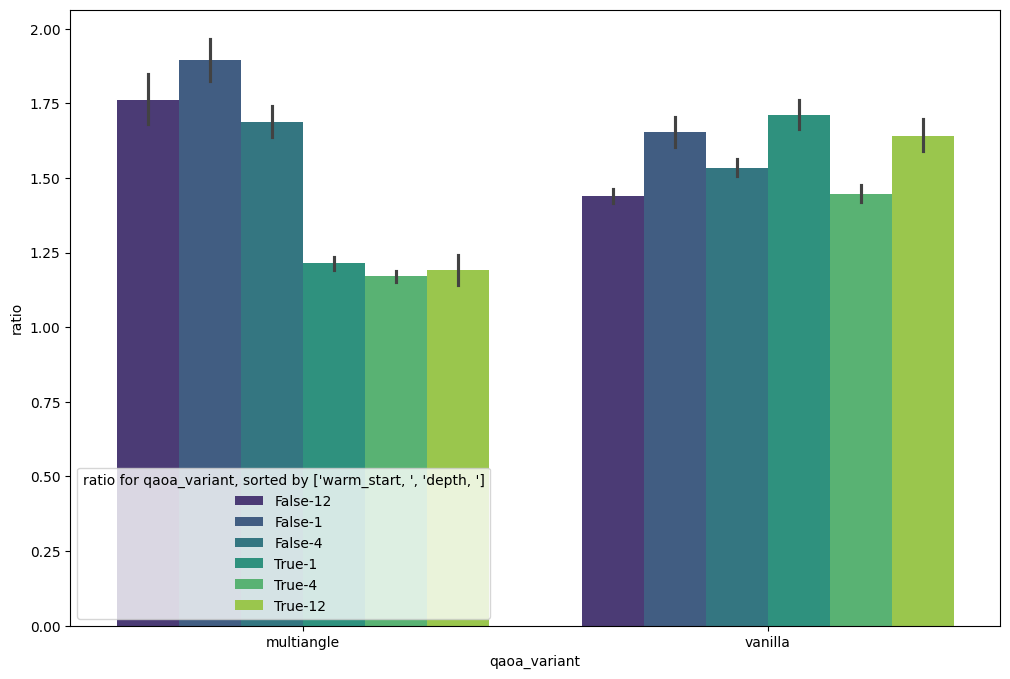

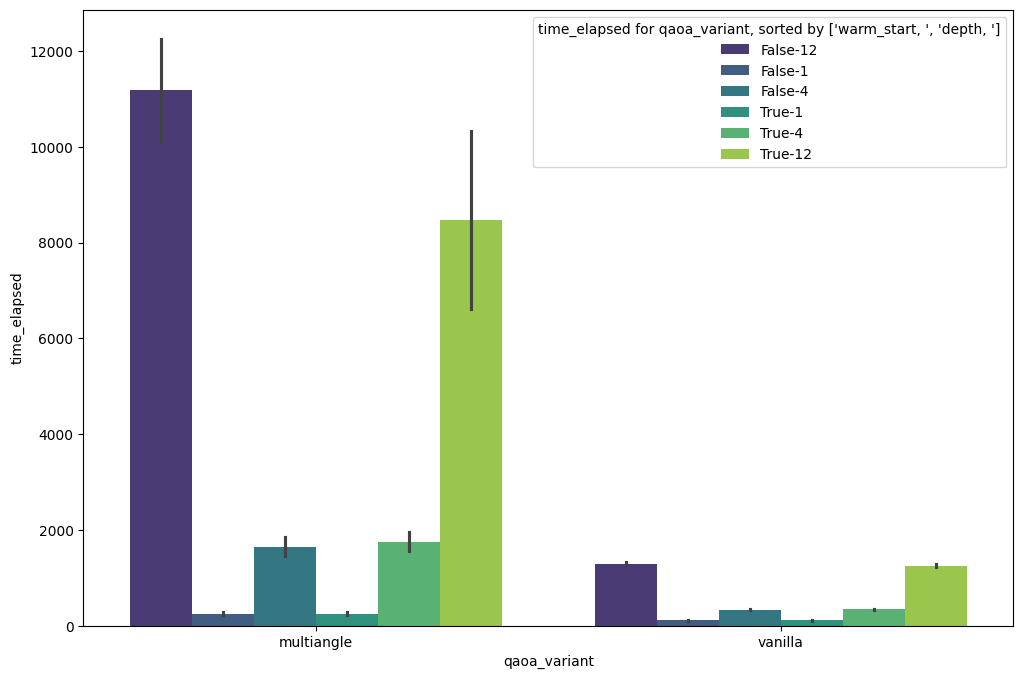

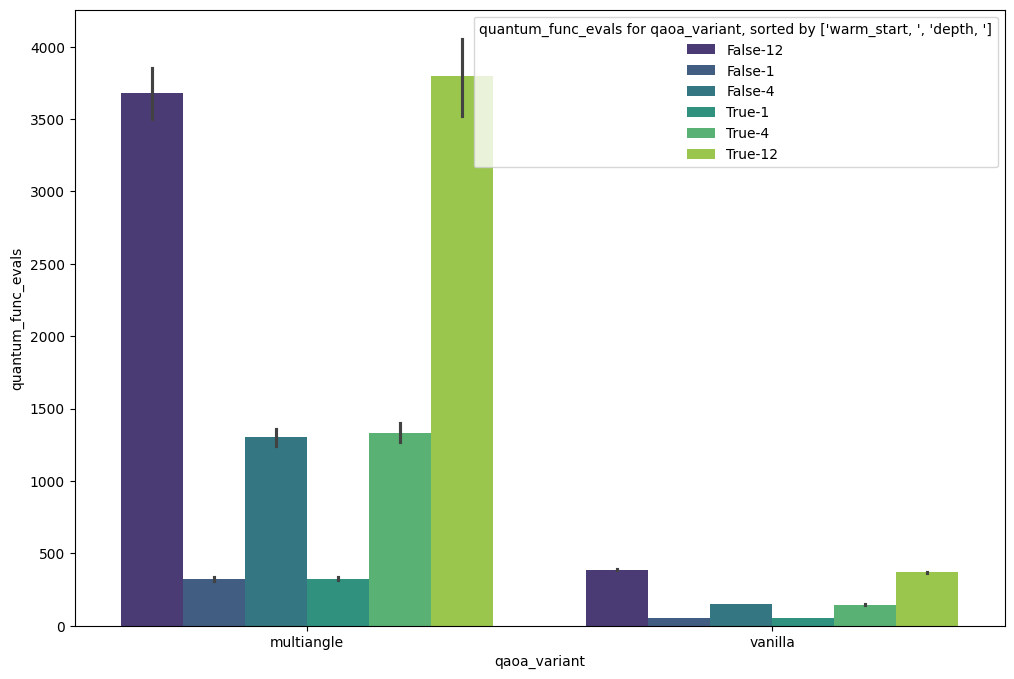

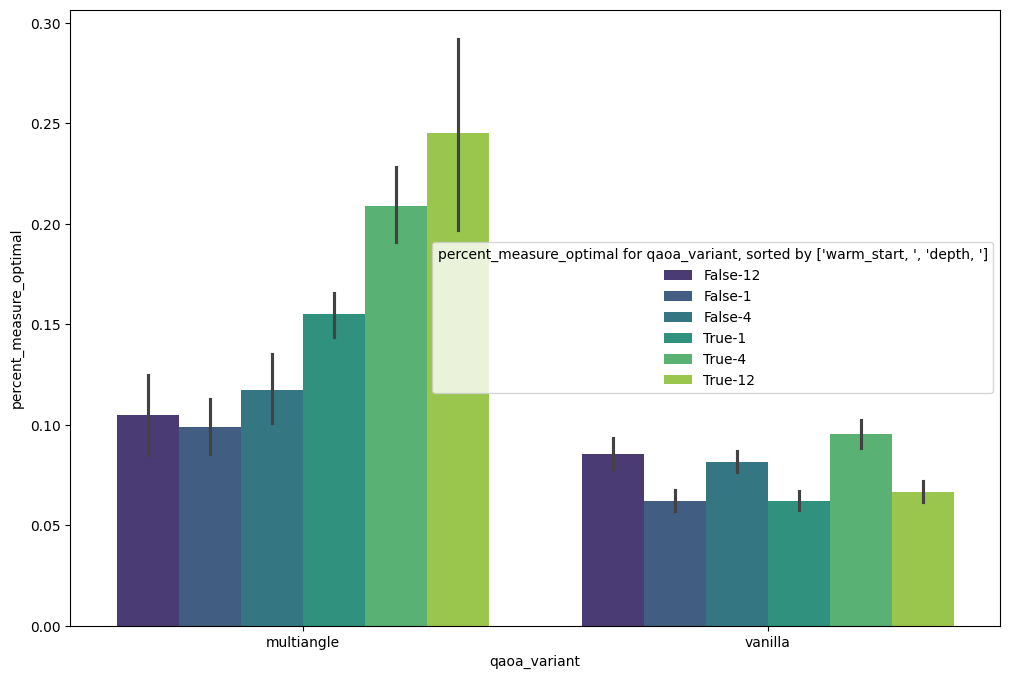

<Figure size 640x480 with 0 Axes>

In [82]:
y_values = ['ratio', 'time_elapsed', 'quantum_func_evals', 'percent_measure_optimal']
x = 'qaoa_variant'
hues = ['warm_start', 'depth']

for y in y_values:
    visualize(results, y, x, hues, 'bar')
plt.tight_layout()
